In [1]:
import os
import pandas as pd
import numpy as np
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models
from torchvision import transforms, datasets
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from PIL import Image
import optuna

# Data Prep

In [2]:
# class to create the dataset
class create_dataset(Dataset):
    def __init__(self, root_dir, transform=None, max_images=None, indices=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images = []
        self.labels = []

        self.label_mapping = {'0Normal': 0, '1Doubtful': 1, '2Mild': 2, '3Moderate': 3, '4Severe': 4} # Mapping of folder names to labels

        all_images = []
        all_labels = []


        # Loop through the folders and collect image paths and labels
        for folder in os.listdir(root_dir):
            folder_path = os.path.join(root_dir, folder)
            if os.path.isdir(folder_path):
                label = self.label_mapping[folder]
                for file_name in os.listdir(folder_path):
                    file_path = os.path.join(folder_path, file_name)
                    all_images.append(file_path)
                    all_labels.append(label)

        # If max_images is specified, select a random subset
        if max_images is not None:
            indices = random.sample(range(len(all_images)), max_images)

        # If indices are specified, use them to select the subset
        if indices is not None:
            self.images = [all_images[i] for i in indices]
            self.labels = [all_labels[i] for i in indices]
        else:
            self.images = all_images
            self.labels = all_labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image_path = self.images[idx]
        image = Image.open(image_path).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224
    transforms.ToTensor(),  # Convert to PyTorch tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])  # Normalize pixel values

In [3]:
# Checking for GPU
if torch.cuda.is_available():
    print("GPU is available.")
else:
    print("GPU is not available.")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

GPU is available.
Using device: cuda


In [6]:
# Splitting images 80/20
dataset = create_dataset('MedicalExpert-I', transform=transform) 
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


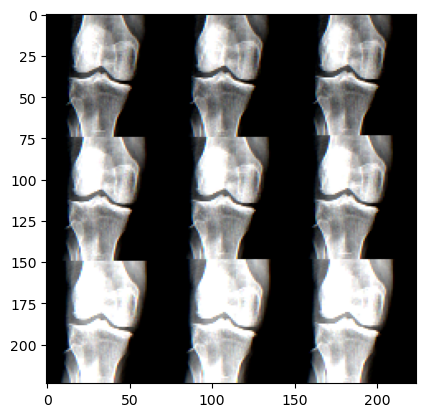

In [7]:
# Sample image from the dataset
train_iter = iter(train_dataset)
images, labels = next(train_iter)
np_image = images.numpy()
plt.imshow(np_image.reshape(224, 224, 3))

# CNN

In [9]:
# Creating CNN model
class CNN(nn.Module):
    def __init__(self, trial, num_classes=5):
        super(CNN, self).__init__()
        # Suggest the number of filters in the convolutional layers
        self.n_filters_conv1 = trial.suggest_categorical('n_filters_conv1', [16, 32, 64])
        self.n_filters_conv2 = trial.suggest_categorical('n_filters_conv2', [32, 64, 128])
        self.n_units_fc1 = trial.suggest_categorical('n_units_fc1', [256, 512, 1024])

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=self.n_filters_conv1, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(self.n_filters_conv1)  # Batch Normalization after conv1
        self.dropout = nn.Dropout2d(p=0.5)  # Dropout layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv2d(in_channels=self.n_filters_conv1, out_channels=self.n_filters_conv2, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(self.n_filters_conv2)  # Batch Normalization after conv2
        self.fc1 = nn.Linear(self.n_filters_conv2 * 56 * 56, self.n_units_fc1)  
        self.fc2 = nn.Linear(self.n_units_fc1, num_classes)

    def forward(self, x):
        x = self.pool(self.dropout(F.relu(self.bn1(self.conv1(x)))))  # Apply BatchNorm and Dropout after ReLU
        x = self.pool(self.dropout(F.relu(self.bn2(self.conv2(x)))))  # Apply BatchNorm and Dropout after ReLU
        x = x.view(-1, self.n_filters_conv2 * 56 * 56)  
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [10]:
# Optuna optimization
def objective(trial):
    # Suggest values for the hyperparameters
    lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
    num_epochs = 40
    batch_size = trial.suggest_categorical('batch_size', [8, 16, 32, 64])
    train_loader = DataLoader(train_dataset, batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size, shuffle=False)
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "RMSprop", "SGD"])

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = CNN(trial).to(device)
    criterion = nn.CrossEntropyLoss()

    if optimizer_name == "Adam":
        optimizer = optim.Adam(model.parameters(), lr=lr)
    elif optimizer_name == "RMSprop":
        optimizer = optim.RMSprop(model.parameters(), lr=lr)
    else:
        optimizer = optim.SGD(model.parameters(), lr=lr)

    # Stop training if the loss does not improve for 10 epochs
    patience = 5  
    best_loss = float('inf')
    wait = 0

    for epoch in range(num_epochs):
        running_loss = 0.0
        total_correct = 0
        total_samples = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)

            # Compute the number of correct predictions
            correct = (torch.argmax(outputs, dim=1) == labels).sum().item()
            total_correct += correct
            total_samples += labels.size(0)

            # Compute the loss
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        # Compute the average loss and overall accuracy for the epoch
        epoch_loss = running_loss / len(train_loader)
        epoch_accuracy = total_correct / total_samples
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}')

        # Check for early stopping
        if epoch_loss < best_loss:
            best_loss = epoch_loss
            wait = 0
        else:
            wait += 1
            if wait >= patience:
                print("Early stopping due to lack of improvement in loss.")
                break

    # Set the model to evaluation mode
    model.eval()

    # Disable gradient computation to save memory
    with torch.no_grad():
        running_loss = 0.0
        running_accuracy = 0.0
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)

            loss = criterion(outputs, labels)
            running_loss += loss.item()

            # Compute the accuracy
            _, preds = torch.max(outputs, 1)
            running_accuracy += (preds == labels).sum().item() / len(inputs)

        # Print the average accuracy and loss for the validation set
        val_accuracy = running_accuracy / len(val_loader)
        val_loss = running_loss / len(val_loader)
        print(f'Validation accuracy: {val_accuracy:.4f}, Validation loss: {val_loss:.4f}')
    return val_accuracy

In [11]:
# Optuna study
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

[I 2024-04-29 12:50:47,357] A new study created in memory with name: no-name-23ef2027-16bd-41dd-a617-9b041e0a64df
/tmp/ipykernel_469085/3272318722.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)


Epoch 1/40, Loss: 1.6111, Accuracy: 0.3144
Epoch 2/40, Loss: 1.4958, Accuracy: 0.3182
Epoch 3/40, Loss: 1.4535, Accuracy: 0.3568
Epoch 4/40, Loss: 1.4284, Accuracy: 0.3977
Epoch 5/40, Loss: 1.4077, Accuracy: 0.3795
Epoch 6/40, Loss: 1.4004, Accuracy: 0.3917
Epoch 7/40, Loss: 1.3693, Accuracy: 0.4106
Epoch 8/40, Loss: 1.3739, Accuracy: 0.4174
Epoch 9/40, Loss: 1.3598, Accuracy: 0.4053
Epoch 10/40, Loss: 1.3391, Accuracy: 0.4273
Epoch 11/40, Loss: 1.3114, Accuracy: 0.4492
Epoch 12/40, Loss: 1.3110, Accuracy: 0.4386
Epoch 13/40, Loss: 1.3156, Accuracy: 0.4432
Epoch 14/40, Loss: 1.2842, Accuracy: 0.4500
Epoch 15/40, Loss: 1.2521, Accuracy: 0.4735
Epoch 16/40, Loss: 1.2483, Accuracy: 0.4750
Epoch 17/40, Loss: 1.2494, Accuracy: 0.4720
Epoch 18/40, Loss: 1.2288, Accuracy: 0.4712
Epoch 19/40, Loss: 1.2241, Accuracy: 0.4833
Epoch 20/40, Loss: 1.1686, Accuracy: 0.5250
Epoch 21/40, Loss: 1.1609, Accuracy: 0.5220
Epoch 22/40, Loss: 1.1875, Accuracy: 0.5288
Epoch 23/40, Loss: 1.1585, Accuracy: 0.52

[I 2024-04-29 12:52:59,960] Trial 0 finished with value: 0.5609375 and parameters: {'lr': 0.0017447150917146734, 'batch_size': 64, 'optimizer': 'SGD', 'n_filters_conv1': 32, 'n_filters_conv2': 64, 'n_units_fc1': 1024}. Best is trial 0 with value: 0.5609375.


Validation accuracy: 0.5609, Validation loss: 1.0614
Epoch 1/40, Loss: 662.8984, Accuracy: 0.2879
Epoch 2/40, Loss: 2.4145, Accuracy: 0.3189
Epoch 3/40, Loss: 2.1013, Accuracy: 0.3159
Epoch 4/40, Loss: 1.8491, Accuracy: 0.3205
Epoch 5/40, Loss: 1.5384, Accuracy: 0.3212
Epoch 6/40, Loss: 1.5823, Accuracy: 0.3205
Epoch 7/40, Loss: 1.7538, Accuracy: 0.3205
Epoch 8/40, Loss: 1.6330, Accuracy: 0.3205
Epoch 9/40, Loss: 1.5288, Accuracy: 0.3182
Epoch 10/40, Loss: 1.6251, Accuracy: 0.3220
Epoch 11/40, Loss: 1.6295, Accuracy: 0.3220
Epoch 12/40, Loss: 1.8464, Accuracy: 0.3197
Epoch 13/40, Loss: 1.5478, Accuracy: 0.3197
Epoch 14/40, Loss: 1.5527, Accuracy: 0.3197
Early stopping due to lack of improvement in loss.


[I 2024-04-29 12:53:45,279] Trial 1 finished with value: 0.28095238095238095 and parameters: {'lr': 0.007962557108567612, 'batch_size': 16, 'optimizer': 'RMSprop', 'n_filters_conv1': 16, 'n_filters_conv2': 64, 'n_units_fc1': 256}. Best is trial 0 with value: 0.5609375.


Validation accuracy: 0.2810, Validation loss: 1.5468
Epoch 1/40, Loss: 2.4941, Accuracy: 0.2886
Epoch 2/40, Loss: 1.6823, Accuracy: 0.3341
Epoch 3/40, Loss: 1.5249, Accuracy: 0.3712
Epoch 4/40, Loss: 1.5028, Accuracy: 0.3985
Epoch 5/40, Loss: 1.4459, Accuracy: 0.4068
Epoch 6/40, Loss: 1.3947, Accuracy: 0.4250
Epoch 7/40, Loss: 1.3663, Accuracy: 0.4477
Epoch 8/40, Loss: 1.2864, Accuracy: 0.4727
Epoch 9/40, Loss: 1.2259, Accuracy: 0.4841
Epoch 10/40, Loss: 1.1883, Accuracy: 0.5280
Epoch 11/40, Loss: 1.2098, Accuracy: 0.5008
Epoch 12/40, Loss: 1.1571, Accuracy: 0.5394
Epoch 13/40, Loss: 1.0919, Accuracy: 0.5576
Epoch 14/40, Loss: 1.0428, Accuracy: 0.5735
Epoch 15/40, Loss: 1.0145, Accuracy: 0.5932
Epoch 16/40, Loss: 0.9831, Accuracy: 0.6258
Epoch 17/40, Loss: 0.9496, Accuracy: 0.6242
Epoch 18/40, Loss: 0.8890, Accuracy: 0.6674
Epoch 19/40, Loss: 0.8720, Accuracy: 0.6659
Epoch 20/40, Loss: 0.8036, Accuracy: 0.6909
Epoch 21/40, Loss: 0.8223, Accuracy: 0.6947
Epoch 22/40, Loss: 0.7509, Accur

[I 2024-04-29 12:56:53,183] Trial 2 finished with value: 0.5773809523809523 and parameters: {'lr': 1.9141509621690485e-05, 'batch_size': 8, 'optimizer': 'RMSprop', 'n_filters_conv1': 32, 'n_filters_conv2': 128, 'n_units_fc1': 256}. Best is trial 2 with value: 0.5773809523809523.


Validation accuracy: 0.5774, Validation loss: 1.2164
Epoch 1/40, Loss: 16.6261, Accuracy: 0.2909
Epoch 2/40, Loss: 1.5775, Accuracy: 0.3273
Epoch 3/40, Loss: 1.5501, Accuracy: 0.3242
Epoch 4/40, Loss: 1.5011, Accuracy: 0.3114
Epoch 5/40, Loss: 1.4853, Accuracy: 0.3174
Epoch 6/40, Loss: 1.4721, Accuracy: 0.3356
Epoch 7/40, Loss: 1.4595, Accuracy: 0.3220
Epoch 8/40, Loss: 1.4679, Accuracy: 0.3129
Epoch 9/40, Loss: 1.4564, Accuracy: 0.3258
Epoch 10/40, Loss: 1.4438, Accuracy: 0.3280
Epoch 11/40, Loss: 1.4321, Accuracy: 0.3250
Epoch 12/40, Loss: 1.4105, Accuracy: 0.3212
Epoch 13/40, Loss: 1.4047, Accuracy: 0.3394
Epoch 14/40, Loss: 1.4029, Accuracy: 0.3356
Epoch 15/40, Loss: 1.4029, Accuracy: 0.3379
Epoch 16/40, Loss: 1.4172, Accuracy: 0.3348
Epoch 17/40, Loss: 1.3695, Accuracy: 0.3386
Epoch 18/40, Loss: 1.3599, Accuracy: 0.3447
Epoch 19/40, Loss: 1.3714, Accuracy: 0.3462
Epoch 20/40, Loss: 1.4457, Accuracy: 0.3455
Epoch 21/40, Loss: 1.3576, Accuracy: 0.3780
Epoch 22/40, Loss: 1.3598, Accu

[I 2024-04-29 12:58:59,647] Trial 3 finished with value: 0.38125 and parameters: {'lr': 0.00033252186978830807, 'batch_size': 32, 'optimizer': 'RMSprop', 'n_filters_conv1': 32, 'n_filters_conv2': 64, 'n_units_fc1': 256}. Best is trial 2 with value: 0.5773809523809523.


Validation accuracy: 0.3812, Validation loss: 1.3375
Epoch 1/40, Loss: 1.5408, Accuracy: 0.3023
Epoch 2/40, Loss: 1.5178, Accuracy: 0.3417
Epoch 3/40, Loss: 1.4963, Accuracy: 0.3424
Epoch 4/40, Loss: 1.4700, Accuracy: 0.3379
Epoch 5/40, Loss: 1.4498, Accuracy: 0.3492
Epoch 6/40, Loss: 1.4630, Accuracy: 0.3568
Epoch 7/40, Loss: 1.4313, Accuracy: 0.3826
Epoch 8/40, Loss: 1.4212, Accuracy: 0.3765
Epoch 9/40, Loss: 1.4246, Accuracy: 0.3773
Epoch 10/40, Loss: 1.3936, Accuracy: 0.3977
Epoch 11/40, Loss: 1.3866, Accuracy: 0.4076
Epoch 12/40, Loss: 1.3769, Accuracy: 0.4114
Epoch 13/40, Loss: 1.3936, Accuracy: 0.4053
Epoch 14/40, Loss: 1.3540, Accuracy: 0.4356
Epoch 15/40, Loss: 1.3451, Accuracy: 0.4212
Epoch 16/40, Loss: 1.3382, Accuracy: 0.4371
Epoch 17/40, Loss: 1.3328, Accuracy: 0.4303
Epoch 18/40, Loss: 1.3351, Accuracy: 0.4318
Epoch 19/40, Loss: 1.3282, Accuracy: 0.4432
Epoch 20/40, Loss: 1.3182, Accuracy: 0.4311
Epoch 21/40, Loss: 1.2834, Accuracy: 0.4659
Epoch 22/40, Loss: 1.2972, Accur

[I 2024-04-29 13:01:14,165] Trial 4 finished with value: 0.4904761904761905 and parameters: {'lr': 0.00021496644297002937, 'batch_size': 16, 'optimizer': 'SGD', 'n_filters_conv1': 32, 'n_filters_conv2': 32, 'n_units_fc1': 512}. Best is trial 2 with value: 0.5773809523809523.


Validation accuracy: 0.4905, Validation loss: 1.1895
Epoch 1/40, Loss: 1.7969, Accuracy: 0.2947
Epoch 2/40, Loss: 1.5244, Accuracy: 0.3333
Epoch 3/40, Loss: 1.4782, Accuracy: 0.3470
Epoch 4/40, Loss: 1.4526, Accuracy: 0.3667
Epoch 5/40, Loss: 1.4254, Accuracy: 0.3735
Epoch 6/40, Loss: 1.3898, Accuracy: 0.3879
Epoch 7/40, Loss: 1.3520, Accuracy: 0.4152
Epoch 8/40, Loss: 1.3296, Accuracy: 0.4159
Epoch 9/40, Loss: 1.3275, Accuracy: 0.4265
Epoch 10/40, Loss: 1.3084, Accuracy: 0.4379
Epoch 11/40, Loss: 1.2799, Accuracy: 0.4432
Epoch 12/40, Loss: 1.2516, Accuracy: 0.4568
Epoch 13/40, Loss: 1.2182, Accuracy: 0.4795
Epoch 14/40, Loss: 1.1944, Accuracy: 0.5015
Epoch 15/40, Loss: 1.1713, Accuracy: 0.5000
Epoch 16/40, Loss: 1.1152, Accuracy: 0.5432
Epoch 17/40, Loss: 1.0558, Accuracy: 0.5803
Epoch 18/40, Loss: 1.0531, Accuracy: 0.5780
Epoch 19/40, Loss: 1.0008, Accuracy: 0.6136
Epoch 20/40, Loss: 0.9763, Accuracy: 0.6023
Epoch 21/40, Loss: 0.9545, Accuracy: 0.6364
Epoch 22/40, Loss: 0.9193, Accur

[I 2024-04-29 13:03:31,879] Trial 5 finished with value: 0.5732142857142857 and parameters: {'lr': 6.536268487638662e-05, 'batch_size': 16, 'optimizer': 'Adam', 'n_filters_conv1': 32, 'n_filters_conv2': 64, 'n_units_fc1': 256}. Best is trial 2 with value: 0.5773809523809523.


Validation accuracy: 0.5732, Validation loss: 1.1066
Epoch 1/40, Loss: 33.1846, Accuracy: 0.2386
Epoch 2/40, Loss: 1.6398, Accuracy: 0.3038
Epoch 3/40, Loss: 1.6539, Accuracy: 0.3030
Epoch 4/40, Loss: 1.5393, Accuracy: 0.3091
Epoch 5/40, Loss: 1.5131, Accuracy: 0.3091
Epoch 6/40, Loss: 1.4996, Accuracy: 0.2955
Epoch 7/40, Loss: 1.4549, Accuracy: 0.3159
Epoch 8/40, Loss: 1.4555, Accuracy: 0.3114
Epoch 9/40, Loss: 1.4163, Accuracy: 0.3227
Epoch 10/40, Loss: 1.4251, Accuracy: 0.3167
Epoch 11/40, Loss: 1.4517, Accuracy: 0.3348
Epoch 12/40, Loss: 1.4343, Accuracy: 0.3417
Epoch 13/40, Loss: 1.3946, Accuracy: 0.3629
Epoch 14/40, Loss: 1.3751, Accuracy: 0.3712
Epoch 15/40, Loss: 1.3664, Accuracy: 0.4023
Epoch 16/40, Loss: 1.3490, Accuracy: 0.4015
Epoch 17/40, Loss: 1.3540, Accuracy: 0.4038
Epoch 18/40, Loss: 1.3394, Accuracy: 0.4091
Epoch 19/40, Loss: 1.3419, Accuracy: 0.4417
Epoch 20/40, Loss: 1.3285, Accuracy: 0.4326
Epoch 21/40, Loss: 1.3013, Accuracy: 0.4470


In [ ]:
# Print the best hyperparameters
print(study.best_params)

In [ ]:
best_params = study.best_params

# New model with the best parameters
class bestCNN(nn.Module):
    def __init__(self, best_params):
        super(bestCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=best_params['n_filters_conv1'], kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(best_params['n_filters_conv1'])  # Batch Normalization after conv1
        self.dropout = nn.Dropout2d(p=0.5)  # Dropout layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv2d(in_channels=best_params['n_filters_conv1'], out_channels=best_params['n_filters_conv2'], kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(best_params['n_filters_conv2'])  # Batch Normalization after conv2
        self.fc1 = nn.Linear(best_params['n_filters_conv2'] * 56 * 56, best_params['n_units_fc1'])  # Adjust 56 * 56 based on the input image size
        self.fc2 = nn.Linear(best_params['n_units_fc1'], 5)

    def forward(self, x):
        x = self.pool(self.dropout(F.relu(self.bn1(self.conv1(x)))))  # Apply BatchNorm and Dropout after ReLU
        x = self.pool(self.dropout(F.relu(self.bn2(self.conv2(x)))))  # Apply BatchNorm and Dropout after ReLU
        x = x.view(-1, best_params['n_filters_conv2'] * 56 * 56)  # Adjust 56 * 56 based on the input image size
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Use the parameters in the model/optimizer
model = bestCNN(best_params).to(device)

In [ ]:
# Data loaders
train_loader = DataLoader(train_dataset, batch_size=best_params['batch_size'], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=best_params['batch_size'], shuffle=False)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer_name = best_params['optimizer']
optimizer_class = getattr(torch.optim, optimizer_name)
optimizer = optimizer_class(model.parameters(), lr=best_params['lr'])

In [ ]:
# Training loop
patience = 5
best_loss = float('inf')  
wait = 0  
num_epochs = 40

for epoch in range(num_epochs):
    running_loss = 0.0
    total_correct = 0
    total_samples = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)

        correct = (torch.argmax(outputs, dim=1) == labels).sum().item()
        total_correct += correct
        total_samples += labels.size(0)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = total_correct / total_samples
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}')

    if epoch_loss < best_loss:
        best_loss = epoch_loss
        wait = 0
    else:
        wait += 1
        if wait >= patience:
            print("Early stopping due to lack of improvement in loss.")
            break

model.eval()

with torch.no_grad():
    running_loss = 0.0
    running_accuracy = 0.0
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)

        loss = criterion(outputs, labels)
        running_loss += loss.item()

        _, preds = torch.max(outputs, 1)
        running_accuracy += (preds == labels).sum().item() / len(inputs)

    val_accuracy = running_accuracy / len(val_loader)
    val_loss = running_loss / len(val_loader)
    print(f'Validation accuracy: {val_accuracy:.4f}, Validation loss: {val_loss:.4f}')

# VGG19

In [ ]:
class VGG19(nn.Module):
    def __init__(self, trial):
        super(VGG19, self).__init__()
        self.vgg19 = models.vgg19(pretrained=True) # Freeze the pre-trained layers
        for param in self.vgg19.features.parameters():
            param.requires_grad = False
        num_classes = 5  
        self.vgg19.classifier[6] = nn.Linear(self.vgg19.classifier[6].in_features, num_classes)

    def forward(self, x):
        return self.vgg19(x)

In [ ]:
def objective(trial):
    lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
    num_epochs = 40
    batch_size = trial.suggest_categorical('batch_size', [8, 16, 32, 64])
    train_loader = DataLoader(train_dataset, batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size, shuffle=False)
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "RMSprop", "SGD"])

    model = VGG19(trial).to(device)
    criterion = nn.CrossEntropyLoss()

    if optimizer_name == "Adam":
        optimizer = optim.Adam(model.parameters(), lr=lr)
    elif optimizer_name == "RMSprop":
        optimizer = optim.RMSprop(model.parameters(), lr=lr)
    else:
        optimizer = optim.SGD(model.parameters(), lr=lr)

    patience = 5
    best_loss = float('inf')  # Best loss achieved so far
    wait = 0  

    for epoch in range(num_epochs):
        running_loss = 0.0
        total_correct = 0
        total_samples = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)

            correct = (torch.argmax(outputs, dim=1) == labels).sum().item()
            total_correct += correct
            total_samples += labels.size(0)

            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        epoch_loss = running_loss / len(train_loader)
        epoch_accuracy = total_correct / total_samples
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}')

        if epoch_loss < best_loss:
            best_loss = epoch_loss
            wait = 0
        else:
            wait += 1
            if wait >= patience:
                print("Early stopping due to lack of improvement in loss.")
                break

    model.eval()

    with torch.no_grad():
        running_loss = 0.0
        running_accuracy = 0.0
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)

            loss = criterion(outputs, labels)
            running_loss += loss.item()

            _, preds = torch.max(outputs, 1)
            running_accuracy += (preds == labels).sum().item() / len(inputs)

        val_accuracy = running_accuracy / len(val_loader)
        val_loss = running_loss / len(val_loader)
        print(f'Validation accuracy: {val_accuracy:.4f}, Validation loss: {val_loss:.4f}')
    return val_accuracy

In [ ]:
vgg19 = optuna.create_study(direction='maximize')
vgg19.optimize(objective, n_trials=10)

In [ ]:
print(vgg19.best_params)

In [ ]:
best_params = vgg19.best_params

train_loader = DataLoader(train_dataset, batch_size=best_params['batch_size'], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=best_params['batch_size'], shuffle=False)

model = models.vgg19(pretrained=True)
for param in model.parameters():
    param.requires_grad = False
num_classes = 5  
model = model.to(device)
model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes).to(device)

for layer in model.classifier:
    if isinstance(layer, nn.Linear):
        layer.bias.data = layer.bias.data.to(device)
        layer.weight.data = layer.weight.data.to(device)

criterion = nn.CrossEntropyLoss()
optimizer_name = best_params['optimizer']
optimizer_class = getattr(torch.optim, optimizer_name)
optimizer = optimizer_class(model.parameters(), lr=best_params['lr'])

In [ ]:
patience = 5  
best_loss = float('inf')  
wait = 0 
num_epochs = 40

for epoch in range(num_epochs):
    running_loss = 0.0
    total_correct = 0
    total_samples = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)

        correct = (torch.argmax(outputs, dim=1) == labels).sum().item()
        total_correct += correct
        total_samples += labels.size(0)

        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = total_correct / total_samples
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}')

    if epoch_loss < best_loss:
        best_loss = epoch_loss
        wait = 0
    else:
        wait += 1
        if wait >= patience:
            print("Early stopping due to lack of improvement in loss.")
            break

model.eval()

with torch.no_grad():
    running_loss = 0.0
    running_accuracy = 0.0
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)

        loss = criterion(outputs, labels)
        running_loss += loss.item()

        _, preds = torch.max(outputs, 1)
        running_accuracy += (preds == labels).sum().item() / len(inputs)

    val_accuracy = running_accuracy / len(val_loader)
    val_loss = running_loss / len(val_loader)
    print(f'Validation accuracy: {val_accuracy:.4f}, Validation loss: {val_loss:.4f}')

# ResNet50

In [ ]:
class resnet(nn.Module):
    def __init__(self, trial):
        super(resnet, self).__init__()
        self.resnet50 = models.resnet50(pretrained=True)
        # Freeze the pre-trained layers
        for param in self.resnet50.parameters():
            param.requires_grad = False
        num_classes = 5 
        self.resnet50.fc = nn.Linear(self.resnet50.fc.in_features, num_classes)

    def forward(self, x):
        return self.resnet50(x)

In [ ]:
def objective(trial):
    lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
    num_epochs = 40
    batch_size = trial.suggest_categorical('batch_size', [8, 16, 32, 64])
    train_loader = DataLoader(train_dataset, batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size, shuffle=False)
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "RMSprop", "SGD"])

    model = resnet(trial).to(device)
    criterion = nn.CrossEntropyLoss()

    if optimizer_name == "Adam":
        optimizer = optim.Adam(model.parameters(), lr=lr)
    elif optimizer_name == "RMSprop":
        optimizer = optim.RMSprop(model.parameters(), lr=lr)
    else:
        optimizer = optim.SGD(model.parameters(), lr=lr)

    patience = 5
    best_loss = float('inf') 
    wait = 0 

    for epoch in range(num_epochs):
        running_loss = 0.0
        total_correct = 0
        total_samples = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)

            correct = (torch.argmax(outputs, dim=1) == labels).sum().item()
            total_correct += correct
            total_samples += labels.size(0)

            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        epoch_loss = running_loss / len(train_loader)
        epoch_accuracy = total_correct / total_samples
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}')

        # Check for early stopping
        if epoch_loss < best_loss:
            best_loss = epoch_loss
            wait = 0
        else:
            wait += 1
            if wait >= patience:
                print("Early stopping due to lack of improvement in loss.")
                break

    model.eval()

    with torch.no_grad():
        running_loss = 0.0
        running_accuracy = 0.0
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)

            loss = criterion(outputs, labels)
            running_loss += loss.item()

            _, preds = torch.max(outputs, 1)
            running_accuracy += (preds == labels).sum().item() / len(inputs)

        val_accuracy = running_accuracy / len(val_loader)
        val_loss = running_loss / len(val_loader)
        print(f'Validation accuracy: {val_accuracy:.4f}, Validation loss: {val_loss:.4f}')
    return val_accuracy

In [ ]:
resnet50 = optuna.create_study(direction='maximize')
resnet50.optimize(objective, n_trials=10)

In [ ]:
print(resnet50.best_params)

In [ ]:
best_params = resnet50.best_params

train_loader = DataLoader(train_dataset, batch_size=best_params['batch_size'], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=best_params['batch_size'], shuffle=False)

model = models.resnet50(pretrained=True)
num_ftrs = model.fc.in_features
num_classes = 5
model.fc = nn.Linear(num_ftrs, num_classes)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer_name = best_params['optimizer']
optimizer_class = getattr(torch.optim, optimizer_name)
optimizer = optimizer_class(model.parameters(), lr=best_params['lr'])

In [ ]:
patience = 5  
best_loss = float('inf')  
wait = 0  
num_epochs = 40

for epoch in range(num_epochs):
    running_loss = 0.0
    total_correct = 0
    total_samples = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)

        correct = (torch.argmax(outputs, dim=1) == labels).sum().item()
        total_correct += correct
        total_samples += labels.size(0)

        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = total_correct / total_samples
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}')

    if epoch_loss < best_loss:
        best_loss = epoch_loss
        wait = 0
    else:
        wait += 1
        if wait >= patience:
            print("Early stopping due to lack of improvement in loss.")
            break

model.eval()

with torch.no_grad():
    running_loss = 0.0
    running_accuracy = 0.0
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)

        loss = criterion(outputs, labels)
        running_loss += loss.item()

        _, preds = torch.max(outputs, 1)
        running_accuracy += (preds == labels).sum().item() / len(inputs)

    val_accuracy = running_accuracy / len(val_loader)
    val_loss = running_loss / len(val_loader)
    print(f'Validation accuracy: {val_accuracy:.4f}, Validation loss: {val_loss:.4f}')

# Combined CNN

In [ ]:
vgg19 = models.vgg19(pretrained=True).to(device)

# Freeze the pre-trained layers
for param in vgg19.features.parameters():
    param.requires_grad = False

In [ ]:
class CustomCNN(nn.Module):
    def __init__(self, trial, num_classes=5):
        super(CustomCNN, self).__init__()
        # Suggest the number of filters in the convolutional layers
        self.n_filters_conv1 = trial.suggest_categorical('n_filters_conv1', [16, 32, 64])
        self.n_filters_conv2 = trial.suggest_categorical('n_filters_conv2', [32, 64, 128])
        self.n_units_fc1 = trial.suggest_categorical('n_units_fc1', [256, 512, 1024])

        self.conv1 = nn.Conv2d(in_channels=512, out_channels=self.n_filters_conv1, kernel_size=3, stride=1, padding=1).to(device)
        self.bn1 = nn.BatchNorm2d(self.n_filters_conv1).to(device)  # Batch Normalization after conv1
        self.dropout = nn.Dropout2d(p=0.1).to(device)  # Dropout layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0).to(device)
        self.conv2 = nn.Conv2d(in_channels=self.n_filters_conv1, out_channels=self.n_filters_conv2, kernel_size=3, stride=1, padding=1).to(device)
        self.bn2 = nn.BatchNorm2d(self.n_filters_conv2).to(device)  # Batch Normalization after conv2

        # Compute the size of the flattened feature map
        with torch.no_grad():
            dummy_input = torch.zeros(1, 3, 224, 224).to(device)
            dummy_output = self.pool(self.dropout(F.relu(self.bn2(self.conv2(self.pool(self.dropout(F.relu(self.bn1(self.conv1(vgg19.features(dummy_input)))))))))))  # Apply BatchNorm and Dropout after ReLU
            feature_map_size = dummy_output.size(2) * dummy_output.size(3)

        self.fc1 = nn.Linear(self.n_filters_conv2 * feature_map_size, self.n_units_fc1)
        self.fc2 = nn.Linear(self.n_units_fc1, num_classes)

    def forward(self, x):
        x = vgg19.features(x)
        x = x.to(device)
        x = self.pool(self.dropout(F.relu(self.bn1(self.conv1(x)))))  # Apply BatchNorm and Dropout after ReLU
        x = self.pool(self.dropout(F.relu(self.bn2(self.conv2(x)))))  # Apply BatchNorm and Dropout after ReLU
        x = x.view(-1, self.n_filters_conv2 * x.size(2) * x.size(3))
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [ ]:
def objective(trial):
    lr = trial.suggest_float('lr', 1e-5, 1e-2, log=True)
    num_epochs = 40
    batch_size = trial.suggest_categorical('batch_size', [8, 16, 32, 64])
    train_loader = DataLoader(train_dataset, batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size, shuffle=False)
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "RMSprop", "SGD"])

    model = CustomCNN(trial).to(device)
    criterion = nn.CrossEntropyLoss()

    if optimizer_name == "Adam":
        optimizer = optim.Adam(model.parameters(), lr=lr)
    elif optimizer_name == "RMSprop":
        optimizer = optim.RMSprop(model.parameters(), lr=lr)
    else:
        optimizer = optim.SGD(model.parameters(), lr=lr)

    patience = 5
    best_loss = float('inf') 
    wait = 0  

    for epoch in range(num_epochs):
        running_loss = 0.0
        total_correct = 0
        total_samples = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)

            correct = (torch.argmax(outputs, dim=1) == labels).sum().item()
            total_correct += correct
            total_samples += labels.size(0)

            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        epoch_loss = running_loss / len(train_loader)
        epoch_accuracy = total_correct / total_samples
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}')

        if epoch_loss < best_loss:
            best_loss = epoch_loss
            wait = 0
        else:
            wait += 1
            if wait >= patience:
                print("Early stopping due to lack of improvement in loss.")
                break

    model.eval()

    with torch.no_grad():
        running_loss = 0.0
        running_accuracy = 0.0
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)

            loss = criterion(outputs, labels)
            running_loss += loss.item()

            _, preds = torch.max(outputs, 1)
            running_accuracy += (preds == labels).sum().item() / len(inputs)

        val_accuracy = running_accuracy / len(val_loader)
        val_loss = running_loss / len(val_loader)
        print(f'Validation accuracy: {val_accuracy:.4f}, Validation loss: {val_loss:.4f}')
    return val_accuracy

In [ ]:
combined= optuna.create_study(direction='maximize')
combined.optimize(objective, n_trials=10)

In [ ]:
print(combined.best_params)

In [ ]:
best_params = combined.best_params

# Define the best CNN model
class bestCNN(nn.Module):
    def __init__(self, best_params):
        super(bestCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=512, out_channels=best_params['n_filters_conv1'], kernel_size=3, stride=1, padding=1).to(device)
        self.bn1 = nn.BatchNorm2d(best_params['n_filters_conv1']).to(device)  # Batch Normalization after conv1
        self.dropout = nn.Dropout2d(p=0.1).to(device)  # Dropout layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0).to(device)
        self.conv2 = nn.Conv2d(in_channels=best_params['n_filters_conv1'], out_channels=best_params['n_filters_conv2'], kernel_size=3, stride=1, padding=1).to(device)
        self.bn2 = nn.BatchNorm2d(best_params['n_filters_conv2']).to(device)  # Batch Normalization after conv2

        # Compute the size of the flattened feature map
        with torch.no_grad():
            dummy_input = torch.zeros(1, 3, 224, 224).to(device)
            dummy_output = self.pool(self.dropout(F.relu(self.bn2(self.conv2(self.pool(self.dropout(F.relu(self.bn1(self.conv1(vgg19.features(dummy_input)))))))))))  # Apply BatchNorm and Dropout after ReLU
            feature_map_size = dummy_output.size(2) * dummy_output.size(3)

        self.fc1 = nn.Linear(best_params['n_filters_conv2']*feature_map_size, best_params['n_units_fc1'])
        self.fc2 = nn.Linear(best_params['n_units_fc1'], 5)

    def forward(self, x):
        x = vgg19.features(x)
        x = x.to(device)
        x = self.pool(self.dropout(F.relu(self.bn1(self.conv1(x)))))  # Apply BatchNorm and Dropout after ReLU
        x = self.pool(self.dropout(F.relu(self.bn2(self.conv2(x)))))  # Apply BatchNorm and Dropout after ReLU
        x = x.view(-1, best_params['n_filters_conv2'] * x.size(2) * x.size(3))
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Use the parameters in the model/optimizer
model = bestCNN(best_params).to(device)


In [ ]:
train_loader = DataLoader(train_dataset, batch_size=best_params['batch_size'], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=best_params['batch_size'], shuffle=False)

criterion = nn.CrossEntropyLoss()
optimizer_name = best_params['optimizer']
optimizer_class = getattr(torch.optim, optimizer_name)
optimizer = optimizer_class(model.parameters(), lr=best_params['lr'])

In [ ]:
patience = 5
best_loss = float('inf')
wait = 0  
num_epochs = 40

for epoch in range(num_epochs):
    running_loss = 0.0
    total_correct = 0
    total_samples = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)

        correct = (torch.argmax(outputs, dim=1) == labels).sum().item()
        total_correct += correct
        total_samples += labels.size(0)

        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = total_correct / total_samples
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}')

    if epoch_loss < best_loss:
        best_loss = epoch_loss
        wait = 0
    else:
        wait += 1
        if wait >= patience:
            print("Early stopping due to lack of improvement in loss.")
            break

model.eval()

with torch.no_grad():
    running_loss = 0.0
    running_accuracy = 0.0
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)

        loss = criterion(outputs, labels)
        running_loss += loss.item()

        _, preds = torch.max(outputs, 1)
        running_accuracy += (preds == labels).sum().item() / len(inputs)

    val_accuracy = running_accuracy / len(val_loader)
    val_loss = running_loss / len(val_loader)
    print(f'Validation accuracy: {val_accuracy:.4f}, Validation loss: {val_loss:.4f}')